In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicide-watch/Suicide_Detection.csv


In [4]:
import random
import numpy as np
import tensorflow as tf

SEED = 42

random.seed(SEED)
np.random.seed(SEED)       # NumPy randomness
tf.random.set_seed(SEED)   # TensorFlow randomness

In [5]:
df=pd.read_csv('/kaggle/input/suicide-watch/Suicide_Detection.csv')

In [6]:
df

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [7]:
df['class']=df['class'].map({'suicide':1,'non-suicide':0})

In [8]:
df

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,1
1,3,Am I weird I don't get affected by compliments...,0
2,4,Finally 2020 is almost over... So I can never ...,0
3,8,i need helpjust help me im crying so hard,1
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",1
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,0
232070,348106,You how you can tell i have so many friends an...,0
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,0
232072,348108,The usual stuff you find hereI'm not posting t...,1


In [9]:
df['class'].value_counts()

class
1    116037
0    116037
Name: count, dtype: int64

In [10]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [11]:
import re

def cleaning(text):
    text=text.lower()
    text=re.sub(r'https\S+','<URL>',text)
    text=re.sub(r'@\w+','<USER>',text)
    text=re.sub('\s+',' ',text).strip()

    return text

df['text']=df['text'].apply(cleaning)

In [12]:
df

,text,class
0,ex wife threatening suiciderecently i left my ...,1
1,am i weird i don't get affected by compliments...,0
2,finally 2020 is almost over... so i can never ...,0
3,i need helpjust help me im crying so hard,1
4,"i’m so losthello, my name is adam (16) and i’v...",1
...,...,...
232069,if you don't like rock then your not going to ...,0
232070,you how you can tell i have so many friends an...,0
232071,pee probably tastes like salty tea😏💦‼️ can som...,0
232072,the usual stuff you find herei'm not posting t...,1


In [13]:
from sklearn.model_selection import train_test_split

train_x,temp_x,train_y,temp_y=train_test_split(
    df['text'],df['class'],
    test_size=0.3,
    random_state=SEED)

val_x,test_x,val_y,test_y=train_test_split(
    temp_x,temp_y,
    test_size=0.5,
    random_state=SEED
)

In [14]:
train_text=train_x.fillna("").astype(str).tolist()
test_text=test_x.fillna("").astype(str).tolist()
val_text=val_x.fillna("").astype(str).tolist()

train_label=train_y.tolist()
test_label=test_y.tolist()
val_label=val_y.tolist()

In [15]:
from transformers import AutoTokenizer
import tensorflow as tf

model_name='roberta-base'

tokenizer=AutoTokenizer.from_pretrained(model_name,use_fast=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [16]:
def tokenize_text(text,label=None,max_length=128):
    encodings=tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )
    if label is not None:
        dataset=tf.data.Dataset.from_tensor_slices((dict(encodings),label))
        return dataset

    return encodings

In [17]:
train_set=tokenize_text(train_text,train_label)
test_set=tokenize_text(test_text,test_label)
val_set=tokenize_text(val_text,val_label)

train_set=train_set.shuffle(1000,seed=SEED).batch(16)
test_set=test_set.batch(16)
val_set=val_set.batch(16)

I0000 00:00:1756717551.437519      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [18]:
from transformers import TFRobertaForSequenceClassification

model=TFRobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [19]:
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 classifier (TFRobertaClass  multiple                  592130    
 ificationHead)                                                  
                                                                 
Total params: 124647170 (475.49 MB)
Trainable params: 124647170 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.roberta.trainable=False

for layer in model.roberta.encoder.layer[-4:]:
    layer.trainable=True
    

In [21]:
optimizer=tf.keras.optimizers.Adam(
    learning_rate=2e-5,
    epsilon=1e-8
)

loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

callback_list=[
    tf.keras.callbacks.EarlyStopping (monitor='val_loss',patience=2,restore_best_weights=True)
]

In [22]:
history=model.fit(
    train_set,
    validation_data=val_set,
    epochs=5,
    callbacks=callback_list
)

Epoch 1/5


I0000 00:00:1756717602.003058     107 service.cc:148] XLA service 0x78e468950660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756717602.003638     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756717602.080602     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756717602.214789     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10154/10154 [==============================] - 1244s 120ms/step - loss: 0.3364 - accuracy: 0.8817 - val_loss: 0.2144 - val_accuracy: 0.9226
Epoch 2/5
10154/10154 [==============================] - 1217s 120ms/step - loss: 0.2443 - accuracy: 0.9103 - val_loss: 0.1896 - val_accuracy: 0.9309
Epoch 3/5
10154/10154 [==============================] - 1217s 120ms/step - loss: 0.2309 - accuracy: 0.9137 - val_loss: 0.1756 - val_accuracy: 0.9353
Epoch 4/5
10154/10154 [==============================] - 1218s 120ms/step - loss: 0.2249 - accuracy: 0.9144 - val_loss: 0.1733 - val_accuracy: 0.9373
Epoch 5/5
10154/10154 [==============================] - 1217s 120ms/step - loss: 0.2214 - accuracy: 0.9154 - val_loss: 0.1658 - val_accuracy: 0.9381


In [23]:
results=model.evaluate(test_set)

print(f"test loss {results[0]}")
print(f"test accuracy {results[1]}")

2176/2176 [==============================] - 206s 95ms/step - loss: 0.1667 - accuracy: 0.9376
test loss 0.16671960055828094
test accuracy 0.9376364350318909


In [24]:
model.save_pretrained("roberta_model")
tokenizer.save_pretrained("roberta_tokenizer")

('roberta_tokenizer/tokenizer_config.json',
 'roberta_tokenizer/special_tokens_map.json',
 'roberta_tokenizer/vocab.json',
 'roberta_tokenizer/merges.txt',
 'roberta_tokenizer/added_tokens.json',
 'roberta_tokenizer/tokenizer.json')

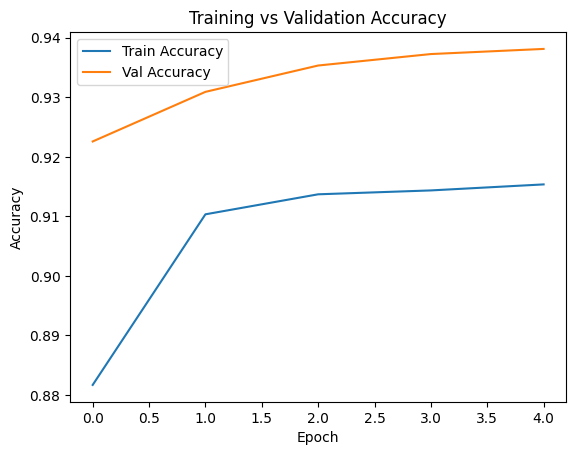

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

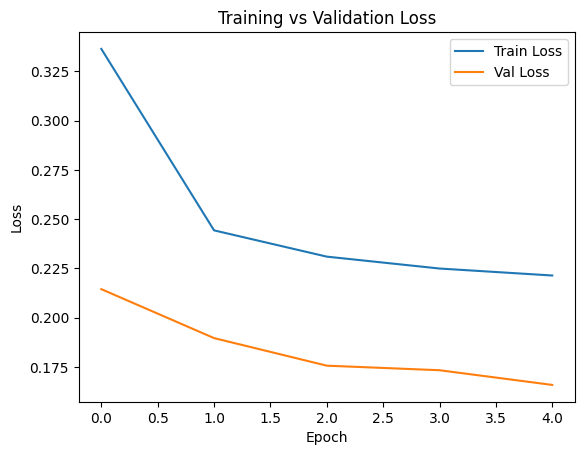

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [27]:
def predict_suicidal(text):
    inputs=tokenizer(
        text,
        max_length=128,
        truncation=True,
        padding=True,
        return_tensors='tf'
    )

    outputs=model(inputs)
    logits=outputs.logits
    probs = tf.nn.softmax(logits, axis=-1).numpy()[0]
    pred_class = int(tf.argmax(probs))
    print(pred_class,"with probability of ",probs.max())
    

In [28]:
predict_suicidal("Love is the cause of everything. My mother's love was the reason I was born, and now my wife's love is the cause of my...")

1 with probability of  0.93044287


In [57]:
y_pred=model.predict(test_set)
y_pred=y_pred.logits

2176/2176 [==============================] - 204s 94ms/step


In [61]:
y_pred_labels=np.argmax(y_pred,axis=1)

# Accuracy
**giving very good accuracy of almost 94%**

In [99]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_auc_score, average_precision_score

accuracy=accuracy_score(test_label,y_pred_labels)
print("Test Accuracy: ",accuracy)

Test Accuracy:  0.9376364472021143


# Confusion Matrix

In [87]:
cm=confusion_matrix(test_label,y_pred_labels)
print(cm)

[[16308  1034]
 [ 1137 16333]]


For this projec  **False Negatives** is more critical ,

**False Negative rate** = 1137/(1137+16333) = 0.065 = ***6.5%***



#  Classification Report
*Model is **Balanced** and strong **across both classes***

In [89]:
cf_report=classification_report(test_label,y_pred_labels,digits=4)
print(cf_report)

              precision    recall  f1-score   support

           0     0.9348    0.9404    0.9376     17342
           1     0.9405    0.9349    0.9377     17470

    accuracy                         0.9376     34812
   macro avg     0.9376    0.9376    0.9376     34812
weighted avg     0.9377    0.9376    0.9376     34812



# ROC-AUC
**With a ROC-AUC of 0.98, the model is highly effective at distinguishing class 1 (suicidal) from class 0 (non-suicidal) across all probability scores.**



In [96]:
roc_auc = roc_auc_score(test_label, y_pred[:,1])
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.9829864986928841
